In [1]:
import pandas as pd
import numpy as np
import os
import warnings
import seaborn as sns
from matplotlib import pyplot as plt
from phik import phik_matrix
import optuna
from typing import Optional, Union, List
from scipy.stats import kstest
from scipy.stats import zscore
from scipy.stats import ks_2samp, chi2_contingency, chisquare
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from optuna.samplers import RandomSampler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve, auc

In [2]:
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.ERROR)
pd.set_option('display.max_columns', None)

DATA_PATH = ''
RANDOM_STATE = 42

In [3]:
local_df_train_path = os.path.join(DATA_PATH, 'shift_ml_2025_train.csv')
local_df_test_path = os.path.join(DATA_PATH, 'shift_ml_2025_test.csv')
local_submission_path = os.path.join(DATA_PATH, 'submission.csv')

In [4]:
df_train = pd.read_csv(local_df_train_path)
df_test = pd.read_csv(local_df_test_path)
submission = pd.read_csv(local_submission_path)

In [5]:
for i,z in zip([df_train,df_test,submission],['df_train','df_test','submission']):
    print(z)
    print()
    print(i.shape)
    print()
    display(i.info())
    display(i.head())
    print(f'ПРОПУСКОВ В {z}: {i.isna().sum().sum()}')
    print(f'ЯВНЫХ ДУБЛИКАТОВ В {z}: {i.duplicated().sum()}')
    print('-------------------------------------------------------------------------------------------------------------')
    print()
    print()

df_train

(1210779, 109)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1210779 entries, 0 to 1210778
Columns: 109 entries, id to тип_предоставления_кредита
dtypes: float64(84), int64(6), object(19)
memory usage: 1006.9+ MB


None

,id,сумма_займа,срок_займа,процентная_ставка,аннуитет,рейтинг,допрейтинг,профессия_заемщика,стаж,владение_жильем,годовой_доход,подтвержден_ли_доход,итоговый_статус_займа,рейтинг_OCR,платежный_график,коэфф_акционных_зачислений_в_остатке,цель_займа,кол_во_субсидий_за_год,индекс_проживания,регион,пдн,пос_стоп_фактор,юридический_статус,кол-во_просрочек_за_два_года,коэфф_невыплаченного_сумм_остатка,коэфф_исходного_платежа,дата_первого_займа,нижний_порог_рейтинга_заемщика,верхний_порог_рейтинга_заемщика,кол-во_заявок_за_полгода,кол-во_месяцев_с_последней_просрочки,кол-во_месяцев_с_последнего_займа,кол-во_открытых_счетов,кол-во_записей_в_общедоступных_документах,оборотный_баланс,коэфф_загрузки_возобновляемого_счета,кол-во_счетов,первоначальный_статус_займа,непогашенная_сумма_из_тела_займов,сумма_выплат_по_просрочкам,пени_за_дефолт,дата_следующей_выплаты,грейд_на_детерминаторе,кол-во_взысканий_за_последний_год,кол-во_месяцев_с_последнего_нарушения,код_политики,тип_займа,совокупный_доход_заемщиков,совокупный_пдн_заемщиков,совокупный_статус_подтверждения_доходов_заемщиков,кол-во_текущих_просроченных_счетов,общая_сумма_взысканий,возвраты_с_учетом_мпл,общая_сумма_на_счетах,кол-во_открытых_счетов_за_полгода,кол-во_текущих_аннуитетных_счетов,кол-во_аннуитетных_счетов_за_год,кол-во_аннуитетных_счетов_за_2_года,кол-во_месяцев_с_посл_аннуитетного_счета,текущий_баланс_по_аннуитетным_счетам,соотношение_сумм_текущего_баланса_к_лимиту_по_аннуитетным_счетам,кол-во_возоб_счетов_за_год,кол-во_возоб_счетов_за_2_года,макс_баланс_по_возоб_счетам,соотношение_баланса_к_лимиту_общее,общий_лимит_по_возоб_счету,кол-во_финансовых_запросов,кол-во_финансовых_операций,кол-во_заявок_на_кредит_за_год,кол-во_открытых_счетов_за_2_года,средний_баланс_текущих_счетов,суммарная_доступная_сумма_займа_по_картам,соотношение_баланса_к_лимиту_по_картам,кол-во_списаний_за_год,сумма_задолженности,кол-во_месяцев_с_первого_аннуитетного_счета,кол-во_месяцев_с_первого_возобновляемого_счета,кол-во_месяцев_с_последнего_возобновляемого_счета,кол-во_месяцев_с_последнего_счета,кол-во_ипотек,кол-во_месяцев_с_последней_карты,кол-во_мес_с_последней_задолженности_по_карте,кол-во_мес_с_последней_заявки,кол-во_мес_с_последней_задолженности_по_возобновляемому_счету,кол-во_счетов_с_просрочкой_4_мес,кол-во_активных_карт,кол-во_активных_возобновляемых_счетов,кол-во_карт_без_нарушений,кол-во_карт,кол-во_аннуитетных_счетов,кол-во_открытых_возобновляемых_счетов,кол-во_возобновляемых_счетов,кол-во_возобновляемых_счетов_с_балансом_более_0,кол-во_счетов_без_нарушений,кол-во_счетов_с_акт_просрочкой_4_мес_обн_2_мес,кол-во_счетов_с_акт_просрочкой_1_мес,кол-во_счетов_с_акт_просрочкой_3_мес_за_2_года,кол-во_счетов_за_посл_год,процент_счетов_без_просрочек,процент_счетов_прев_75_лимита,кол-во_публ_банкротств,кол-во_залогов,кредитный_лимит,кредитный_баланс_без_ипотеки,лимит_по_картам,лимит_по_аннуитетным_счетам,кредитный_баланс_по_возоб_счетам,особая_ситуация,тип_предоставления_кредита
0,68355089,1235000.0,3 года,11.99,41014.0,В,В1,инженер,10+ лет,ИПОТЕКА,1300000.0,Не подтвержден,0,4,n,0.899168,мелкий_бизнес,0,577.0,Новгородская область,16.06,Нет,Нет,1.0,1.345312e+06,0.767016,12-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,а,0.0,0.0,False,NaN,5,0.0,NaN,1.0,Индивидуальный,NaN,NaN,NaN,0.0,0.0,12213,10219800.0,1.0,1.0,0.0,1.0,19.0,900250.0,73.0,2.0,3.0,6472.0,29.0,5590000.0,0.0,0.0,6.0,4.0,486650.0,2891500.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,15700850.0,1973750.0,3965000.0,1233350.0,NaN,Нет,Наличные
1,68341763,1000000.0,5 лет,10.78,21633.0,Б,Б4,водитель грузовика,10+ лет,ИПОТЕКА,1260000.0,Не подтвержден,0,2,n,0.489891,улучшение_жилищных_условий,0,605.0,Республика Татарстан,10.78,Нет,Нет,0.0,1.345312e+06,0.229990,8-2000,695.0,699.0,0.0,NaN,NaN,6.0,0.0,7869.0,56.2,18.0,а,0.0,0.0,NaN,NaN,1,0.0,NaN,1.0,Совместный,3550000.0,13.85,Не подтвержден,0.0,0.0,36245,9484950.0,0.0,1.0,0.0,4.0,19.0,541350.0,73.0,0.0,2.0,2

ПРОПУСКОВ В df_train: 23096083
ЯВНЫХ ДУБЛИКАТОВ В df_train: 0
-------------------------------------------------------------------------------------------------------------


df_test

(134531, 108)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134531 entries, 0 to 134530
Columns: 108 entries, id to тип_предоставления_кредита
dtypes: float64(85), int64(5), object(18)
memory usage: 110.9+ MB


None

,id,сумма_займа,срок_займа,процентная_ставка,аннуитет,рейтинг,допрейтинг,профессия_заемщика,стаж,владение_жильем,годовой_доход,подтвержден_ли_доход,рейтинг_OCR,платежный_график,коэфф_акционных_зачислений_в_остатке,цель_займа,кол_во_субсидий_за_год,индекс_проживания,регион,пдн,пос_стоп_фактор,юридический_статус,кол-во_просрочек_за_два_года,коэфф_невыплаченного_сумм_остатка,коэфф_исходного_платежа,дата_первого_займа,нижний_порог_рейтинга_заемщика,верхний_порог_рейтинга_заемщика,кол-во_заявок_за_полгода,кол-во_месяцев_с_последней_просрочки,кол-во_месяцев_с_последнего_займа,кол-во_открытых_счетов,кол-во_записей_в_общедоступных_документах,оборотный_баланс,коэфф_загрузки_возобновляемого_счета,кол-во_счетов,первоначальный_статус_займа,непогашенная_сумма_из_тела_займов,сумма_выплат_по_просрочкам,пени_за_дефолт,дата_следующей_выплаты,грейд_на_детерминаторе,кол-во_взысканий_за_последний_год,кол-во_месяцев_с_последнего_нарушения,код_политики,тип_займа,совокупный_доход_заемщиков,совокупный_пдн_заемщиков,совокупный_статус_подтверждения_доходов_заемщиков,кол-во_текущих_просроченных_счетов,общая_сумма_взысканий,возвраты_с_учетом_мпл,общая_сумма_на_счетах,кол-во_открытых_счетов_за_полгода,кол-во_текущих_аннуитетных_счетов,кол-во_аннуитетных_счетов_за_год,кол-во_аннуитетных_счетов_за_2_года,кол-во_месяцев_с_посл_аннуитетного_счета,текущий_баланс_по_аннуитетным_счетам,соотношение_сумм_текущего_баланса_к_лимиту_по_аннуитетным_счетам,кол-во_возоб_счетов_за_год,кол-во_возоб_счетов_за_2_года,макс_баланс_по_возоб_счетам,соотношение_баланса_к_лимиту_общее,общий_лимит_по_возоб_счету,кол-во_финансовых_запросов,кол-во_финансовых_операций,кол-во_заявок_на_кредит_за_год,кол-во_открытых_счетов_за_2_года,средний_баланс_текущих_счетов,суммарная_доступная_сумма_займа_по_картам,соотношение_баланса_к_лимиту_по_картам,кол-во_списаний_за_год,сумма_задолженности,кол-во_месяцев_с_первого_аннуитетного_счета,кол-во_месяцев_с_первого_возобновляемого_счета,кол-во_месяцев_с_последнего_возобновляемого_счета,кол-во_месяцев_с_последнего_счета,кол-во_ипотек,кол-во_месяцев_с_последней_карты,кол-во_мес_с_последней_задолженности_по_карте,кол-во_мес_с_последней_заявки,кол-во_мес_с_последней_задолженности_по_возобновляемому_счету,кол-во_счетов_с_просрочкой_4_мес,кол-во_активных_карт,кол-во_активных_возобновляемых_счетов,кол-во_карт_без_нарушений,кол-во_карт,кол-во_аннуитетных_счетов,кол-во_открытых_возобновляемых_счетов,кол-во_возобновляемых_счетов,кол-во_возобновляемых_счетов_с_балансом_более_0,кол-во_счетов_без_нарушений,кол-во_счетов_с_акт_просрочкой_4_мес_обн_2_мес,кол-во_счетов_с_акт_просрочкой_1_мес,кол-во_счетов_с_акт_просрочкой_3_мес_за_2_года,кол-во_счетов_за_посл_год,процент_счетов_без_просрочек,процент_счетов_прев_75_лимита,кол-во_публ_банкротств,кол-во_залогов,кредитный_лимит,кредитный_баланс_без_ипотеки,лимит_по_картам,лимит_по_аннуитетным_счетам,кредитный_баланс_по_возоб_счетам,особая_ситуация,тип_предоставления_кредита
0,85540387,450000.0,3 года,9.49,14413.0,Б,Б2,обслуживание клиентов,10+ лет,ИПОТЕКА,840000.0,Не подтвержден,4,n,0.458947,консолидация_долга,0,601.0,Республика Татарстан,19.09,Нет,Да,0.0,1.345312e+06,0.812613,6-1995,740.0,744.0,0.0,NaN,NaN,11.0,0.0,7735.0,34.1,20.0,а,0.0,0.0,NaN,NaN,1,0.0,NaN,1.0,Индивидуальный,NaN,NaN,NaN,0.0,0.0,92843,3111700.0,0.0,2.0,1.0,2.0,10.0,793850.0,78.0,0.0,1.0,2594.0,55.0,1135000.0,1.0,1.0,2.0,3.0,282900.0,395700.0,45.4,0.0,0.0,112.0,253.0,17.0,10.0,2.0,17.0,NaN,10.0,NaN,0.0,3.0,5.0,4.0,6.0,7.0,8.0,11.0,5.0,11.0,0.0,0.0,0.0,1.0,100.0,75.0,0.0,0.0,4282850.0,1180600.0,725000.0,1022000.0,NaN,Нет,Наличные
1,28112500,400000.0,3 года,6.03,12174.5,А,А1,помощник по правовым вопросам,5 лет,АРЕНДА,1520000.0,Не подтвержден,4,n,0.006964,консолидация_долга,0,112.0,Новосибирская область,20.42,Нет,Нет,0.0,1.345312e+06,0.725167,12-1997,710.0,714.0,0.0,NaN,NaN,14.0,0.0,23650.0,78.6,28.0,б,0.0,0.0,NaN,NaN,1,0.0,NaN,1.0,Индивидуальный,NaN,NaN,NaN,0.0,0.0,43004,2381050.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1505000.0,NaN,NaN,NaN,1.0,18

ПРОПУСКОВ В df_test: 2663443
ЯВНЫХ ДУБЛИКАТОВ В df_test: 0
-------------------------------------------------------------------------------------------------------------


submission

(134531, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134531 entries, 0 to 134530
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      134531 non-null  int64  
 1   proba   134531 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 2.1 MB


None

,id,proba
0,85540387,0.183566
1,28112500,0.157488
2,65731570,0.217320
3,65874747,0.250397
4,57893355,0.172958


ПРОПУСКОВ В submission: 0
ЯВНЫХ ДУБЛИКАТОВ В submission: 0
-------------------------------------------------------------------------------------------------------------




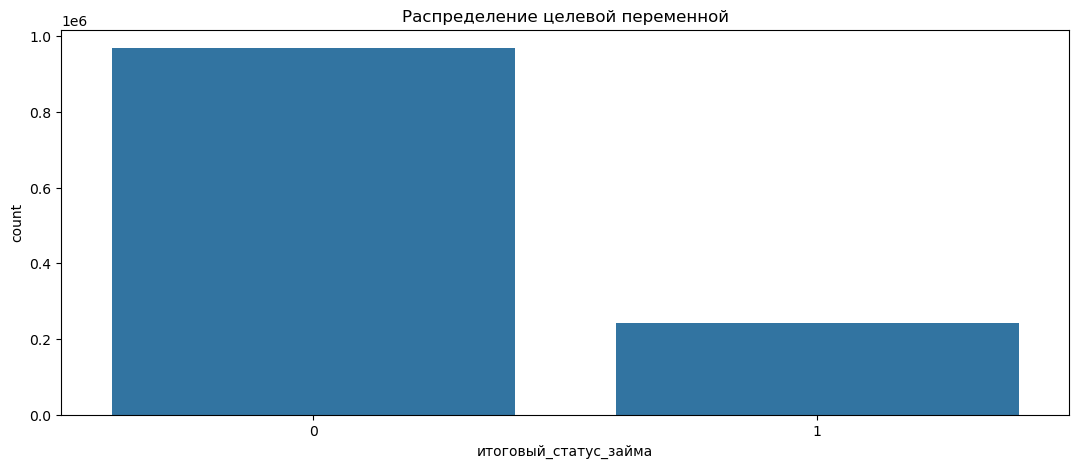

In [6]:
plt.figure(figsize=(13,5));
sns.countplot(data=df_train, x='итоговый_статус_займа');
plt.title(f"Распределение целевой переменной")
plt.show()

Явный дисбаланс классов

In [7]:
def reprez_sample(
    df: pd.DataFrame | pd.Series,
    y: pd.Series = None,
    frac: list | np.ndarray = None,
    random_state: int | float = RANDOM_STATE,
    alpha: float = 0.05
):

    if isinstance(df, pd.DataFrame) and y is None and isinstance(frac, (list, np.ndarray)):
        for f in frac:
            y_sample = df.sample(frac=f, random_state=random_state)
            all_similar = True

            for col in df.columns:
                try:
                    series_full = df[col].dropna()
                    series_sample = y_sample[col].dropna()

                    # Категориальные признаки
                    if series_full.dtype == 'object' or series_full.dtype.name == 'category':
                        
                        full_freq = series_full.value_counts(normalize=True)
                        sample_freq = series_sample.value_counts(normalize=True)

                        categories = full_freq.index.union(sample_freq.index)
                        full_freq = full_freq.reindex(categories, fill_value=0)
                        sample_freq = sample_freq.reindex(categories, fill_value=0)

                        _, p_value = chisquare(f_obs=sample_freq, f_exp=full_freq)
                        test_type = "Chi**2"

                    # Числовые признаки
                    else:
                        _, p_value = ks_2samp(series_full, series_sample)
                        test_type = "KS"

                    if p_value < alpha:
                        print(f'[{test_type}] {col} — p={p_value:.3f}, выборки различны.')
                        all_similar = False
                        break

                except Exception as e:
                    print(f'Ошибка при сравнении "{col}": {e}')
                    all_similar = False
                    break

            if all_similar:
                print(f'Все распределения совпадают при f = {f:.0%}')
                return f

        print('Не удалось найти репрезентативный процент выборки.')
        return None

    elif y is not None:
    # Сравнение двух Series
        x = df.dropna()
        y = y.dropna()

        if x.dtype == 'object' or x.dtype.name == 'category':
            full_freq = x.value_counts(normalize=True)
            sample_freq = y.value_counts(normalize=True)
            categories = full_freq.index.union(sample_freq.index)
            full_freq = full_freq.reindex(categories, fill_value=0)
            sample_freq = sample_freq.reindex(categories, fill_value=0)

            _, p_value = chisquare(f_obs=sample_freq, f_exp=full_freq)
            test_type = "Chi**2"
        else:
            _, p_value = ks_2samp(x, y)
            test_type = "KS"

        if p_value < alpha:
            print(f'[{test_type}] Распределения различны (p={p_value:.3f})')
        else:
            print(f'[{test_type}] Распределения совпадают (p={p_value:.3f})')

        return p_value

    else:
        raise ValueError("Некорректный формат входных данных.")

In [8]:
#sample_ks_2sample(df_train['TotalCharges'], df_test['TotalCharges'])
#sample_ks_2sample(df_train.drop(columns='id'), df_test.drop(columns='id'))

# Сравнение на однородность двух признаков либо датасетов

Отличный вопрос. Ты можешь использовать репрезентативную подвыборку для обучения, но есть несколько ключевых факторов, которые нужно учитывать. Вот подробный разбор:

✅ Когда можно использовать подвыборку (например, 120 тыс. из 1.2 млн)
🔹 1. Если данные действительно избыточны
Если модель не выигрывает от большого объёма (например, простые модели: логистическая регрессия, дерево решений).

Если качество не ухудшается при уменьшении объёма (репрезентативность сохранена, что ты и проверил через ks_2samp).

Особенно полезно на этапе прототипирования — быстрее запускать циклы обучения и подбора гиперпараметров.

🔹 2. Если ресурсы ограничены
Ограничения по оперативной памяти (RAM), GPU/CPU или времени обучения — особенно актуально для больших моделей.

Даже 10% от больших данных может быть достаточно для достижения ~90% от максимального качества.

🔹 3. Для базового анализа или AutoML
Быстрее обучать baseline-модель, искать важные признаки, отсеивать ненужные.

Быстрее проводить кросс-валидацию и grid search.

⚠️ Когда лучше использовать всю выборку
🔸 1. Финальное обучение перед продакшеном
После того как ты настроил гиперпараметры и архитектуру — лучше обучать на всех данных, чтобы получить максимум информации и устойчивость.

🔸 2. Если модель сложная (нейросети, градиентный бустинг)
Такие модели выигрывают от больших объёмов данных — даже если репрезентативность сохранена, больше данных = лучше обобщение.

🔸 3. Когда дисбаланс классов
Если задача несбалансирована, уменьшение выборки может удалить важные редкие случаи.

📌 Рекомендации
Цель	Используй подвыборку?	Объём
Исследование, анализ	✅	5–20%
Подбор модели / GridSearch	✅	10–30%
Финальное обучение	❌	100%
Ограничения по памяти	✅	максимально возможный без потерь

💡 Вывод
➡️ Да, ты можешь использовать подвыборку, если она репрезентативна (и ты это уже проверил).
Для начальных этапов, анализа и отладки — это даже рекомендуется.
Но для продакшен-модели стоит использовать всю обучающую выборку, если позволяют ресурсы.

Хочешь — могу помочь построить пайплайн, где будет обучение на подвыборке + финальное дообучение на всех данных.

In [9]:
fracs = [0.1,0.2, 0.3, 0.5, 0.7]  # список долей подвыборки
#frac_range = np.linspace(0.1, 0.9, 9)
best_frac = reprez_sample(df_train.drop(columns=['id']), frac=fracs)

Все распределения совпадают при f = 10%


In [10]:
lst = []
for i in df_train.columns:
    if df_train[i].isna().sum() / len(df_train[i]) >= 0.5:
        lst.append(i)

len(lst)           

24

In [11]:
def clear_dataset(data: pd.DataFrame):
    df = data.copy()
    lst_many_isna = []
    for i in df.columns:
        if df[i].isna().sum() / len(df[i]) >= 0.5:
            lst_many_isna.append(i)

    cat_like_num = list(df.select_dtypes(include=['object', 'category', 'bool']))

    for i in df.columns[1:]:
        if (df[i].dtype == int or df[i].dtype == float) and df[i].nunique()  <= 30:
            cat_like_num.append(i)

    lst_many_uniq = []
    for i in cat_like_num:
        if df[i].nunique() > 100:
            lst_many_uniq.append(i)        

    df =  df.drop(['id'] + lst_many_isna + lst_many_uniq,axis=1)
    for i in df.columns:
        df[i] = df[i].fillna('NaN')
    return df     


In [12]:
df_train_clean = clear_dataset(df_train)

In [13]:
df_train_EDA = df_train_clean.sample(frac=best_frac,random_state=RANDOM_STATE)

In [14]:
cat_like_num = []

for i in df_train_EDA.columns[1:]:
    if (df_train_EDA[i].dtype == int or df_train_EDA[i].dtype == float) and df_train_EDA[i].nunique()  <= 30:
        cat_like_num.append(i)

In [15]:
NUM_COLS = df_train_EDA.select_dtypes(include=['number']).columns
NUM_COLS = [i for i in NUM_COLS if i not in cat_like_num][1:]

CAT_COLS = list(df_train_EDA.select_dtypes(include=['object', 'category', 'bool']).columns) + cat_like_num

In [16]:
def  outlier_ratio(srs: pd.Series):
    q1 = srs.quantile(0.25)
    q3 = srs.quantile(0.75)
    iqr = q3 - q1
    left = q1 - iqr * 1.5
    right = q3 + iqr * 1.5

    ratio = (srs[srs < left].count() + srs[srs > right].count()) / len(srs)
    return ratio

In [17]:
def EDA_for_num(df: pd.DataFrame, num_cols: list):
    n = len(num_cols)
    cols = 5
    rows = int(np.ceil(n / cols))

    fig, axs = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    axs = axs.flatten()

    for i, col in enumerate(num_cols):
        ax = axs[i]
        df[col].hist(bins='auto', ax=ax)
        outlier_perc = outlier_ratio(df[col])
        ax.set_title(f'Признак "{col}"\nВыбросов: {outlier_perc:.1%}', fontsize=9)

    for j in range(n, len(axs)):
        fig.delaxes(axs[j])

    fig.suptitle('Гистограммы 10 процентов тренировочной выборки для числовых признаков', fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

In [19]:
NUM_COLS

['процентная_ставка',
 'аннуитет',
 'годовой_доход',
 'коэфф_акционных_зачислений_в_остатке',
 'коэфф_исходного_платежа',
 'нижний_порог_рейтинга_заемщика',
 'верхний_порог_рейтинга_заемщика',
 'кол-во_открытых_счетов',
 'оборотный_баланс',
 'кол-во_счетов',
 'сумма_выплат_по_просрочкам',
 'возвраты_с_учетом_мпл',
 'сумма_задолженности']

In [24]:
CAT_COLS

['срок_займа',
 'рейтинг',
 'допрейтинг',
 'стаж',
 'владение_жильем',
 'подтвержден_ли_доход',
 'платежный_график',
 'цель_займа',
 'индекс_проживания',
 'регион',
 'пдн',
 'пос_стоп_фактор',
 'юридический_статус',
 'кол-во_заявок_за_полгода',
 'коэфф_загрузки_возобновляемого_счета',
 'первоначальный_статус_займа',
 'пени_за_дефолт',
 'кол-во_взысканий_за_последний_год',
 'тип_займа',
 'общая_сумма_взысканий',
 'общая_сумма_на_счетах',
 'общий_лимит_по_возоб_счету',
 'кол-во_открытых_счетов_за_2_года',
 'средний_баланс_текущих_счетов',
 'суммарная_доступная_сумма_займа_по_картам',
 'соотношение_баланса_к_лимиту_по_картам',
 'кол-во_списаний_за_год',
 'кол-во_месяцев_с_первого_аннуитетного_счета',
 'кол-во_месяцев_с_первого_возобновляемого_счета',
 'кол-во_месяцев_с_последнего_возобновляемого_счета',
 'кол-во_месяцев_с_последнего_счета',
 'кол-во_ипотек',
 'кол-во_месяцев_с_последней_карты',
 'кол-во_мес_с_последней_заявки',
 'кол-во_счетов_с_просрочкой_4_мес',
 'кол-во_активных_карт',

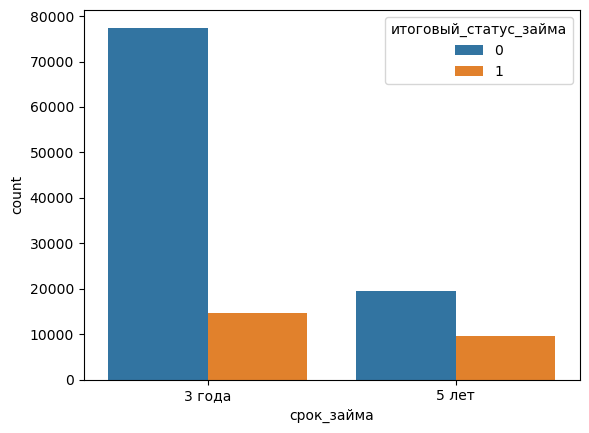

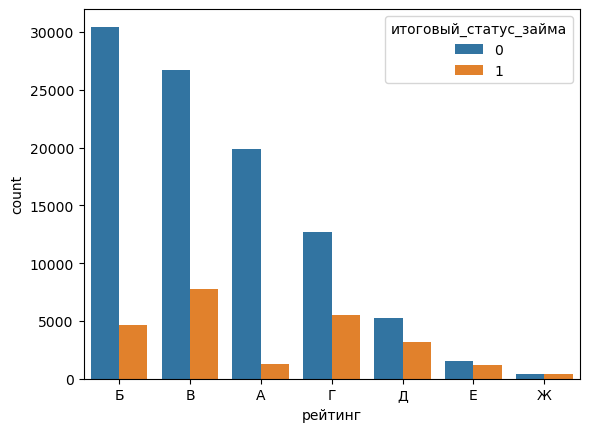

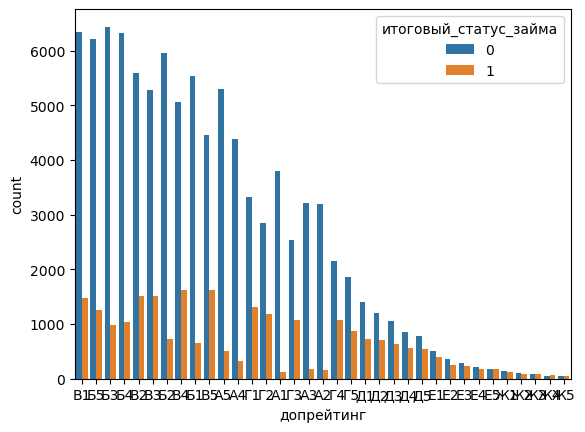

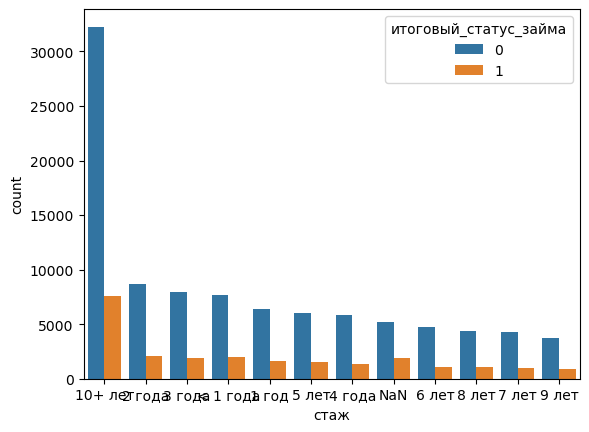

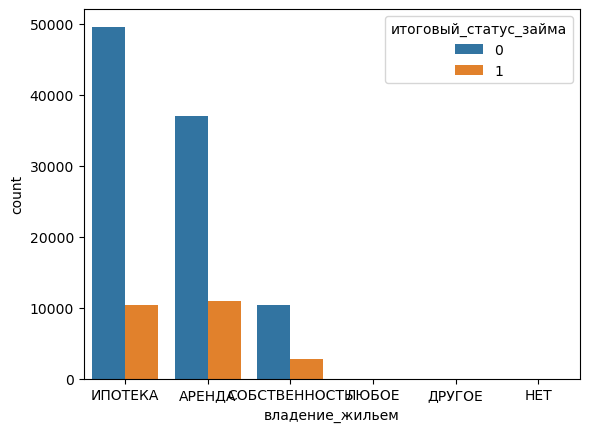

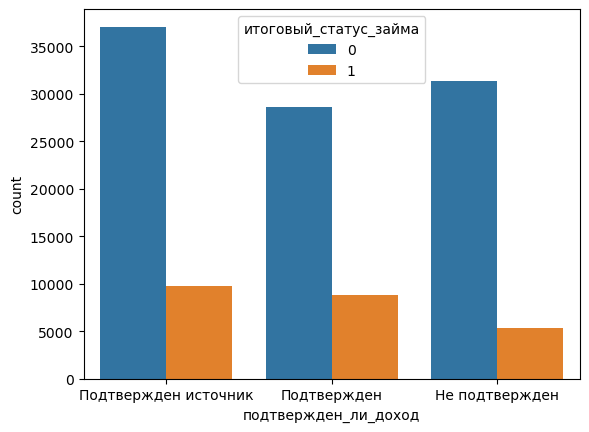

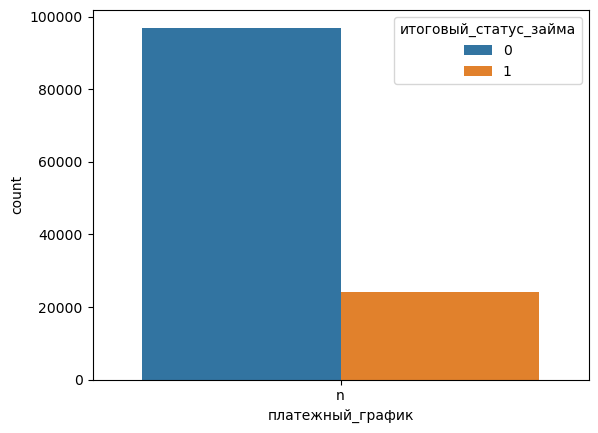

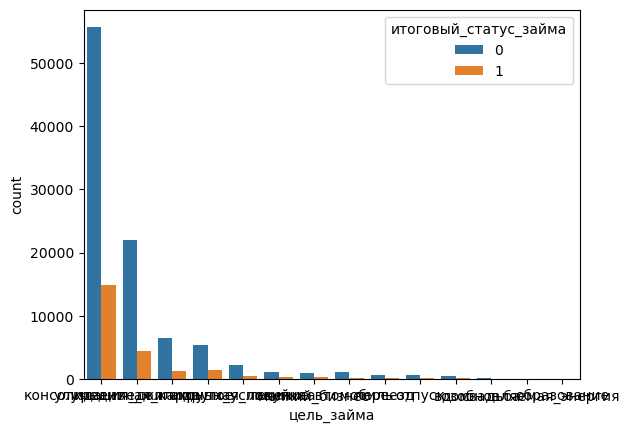

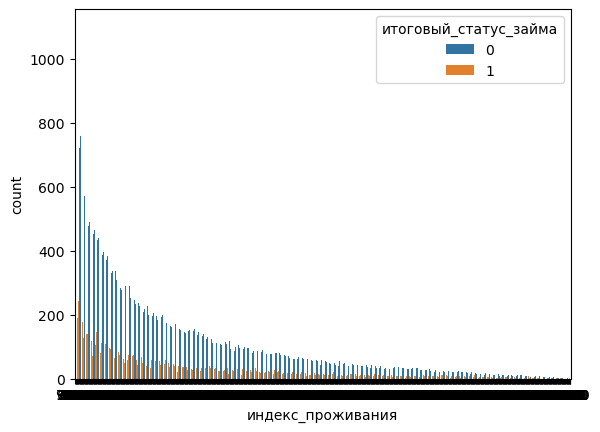

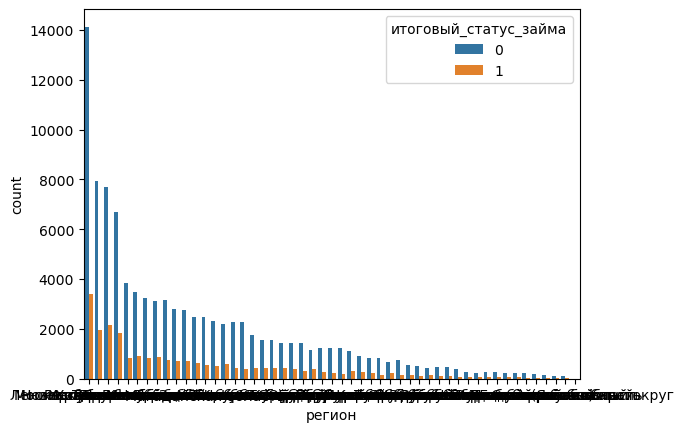

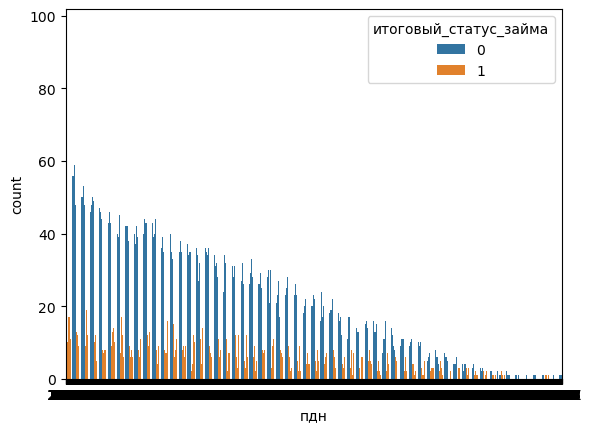

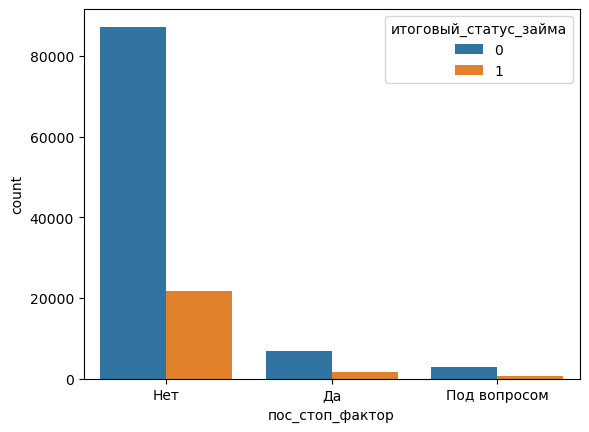

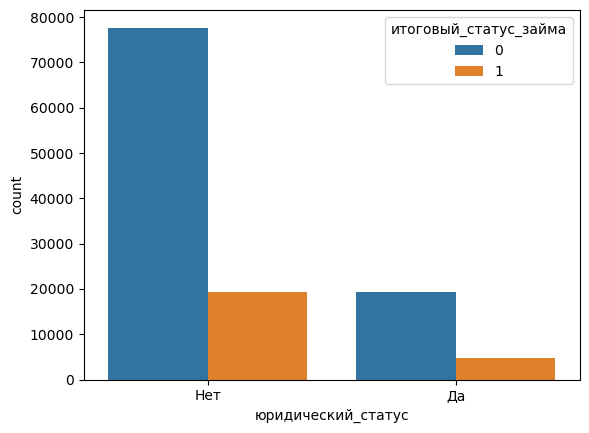

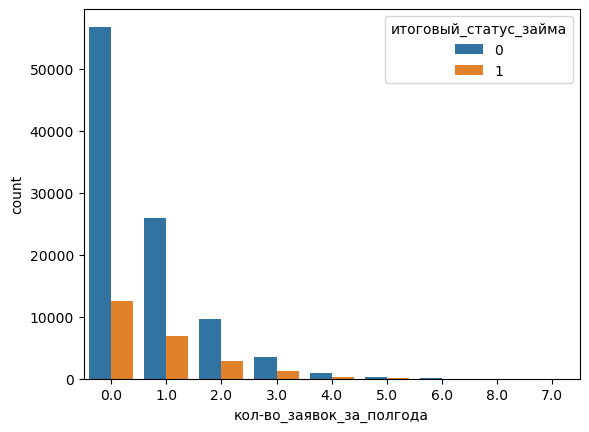

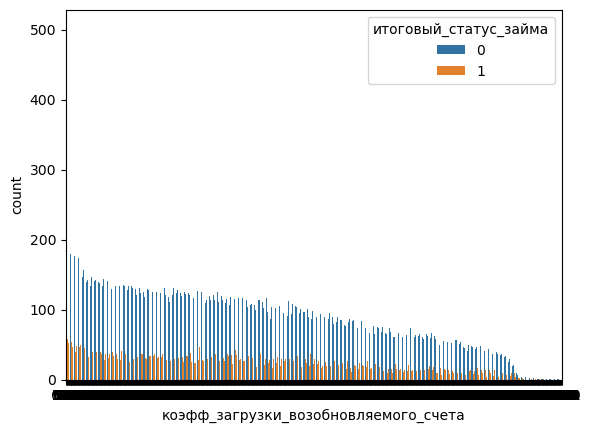

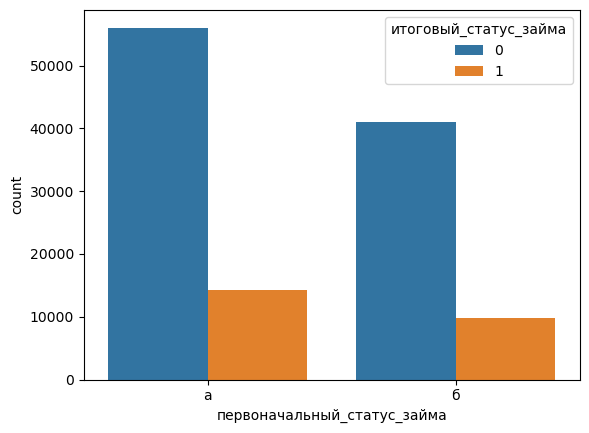

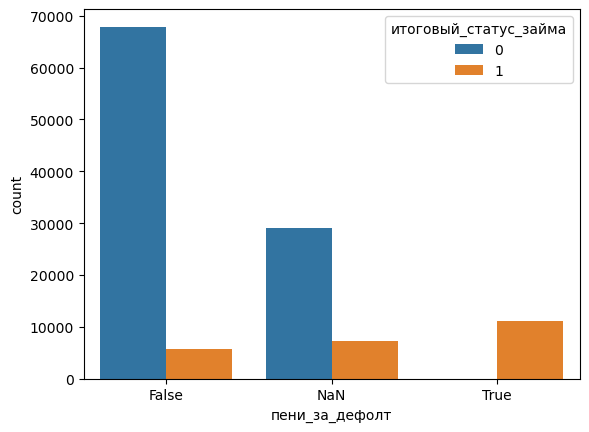

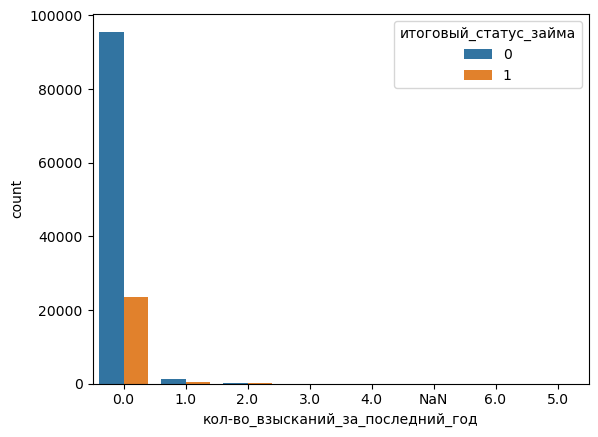

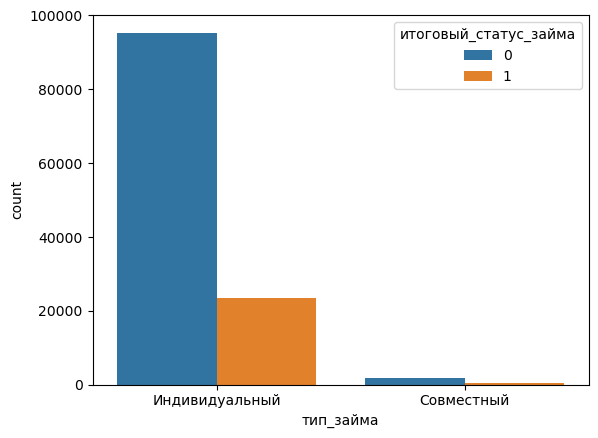

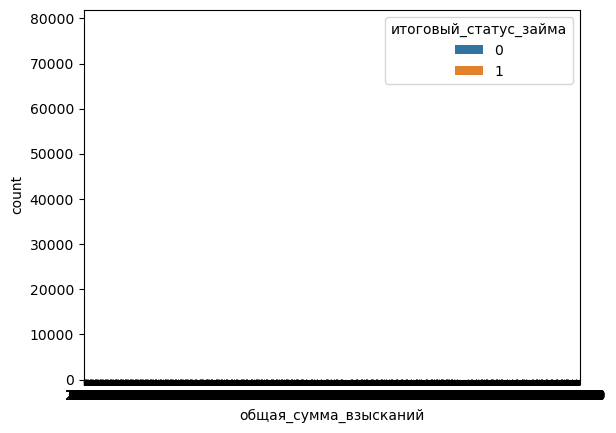

KeyboardInterrupt: 

In [25]:
for i in df_train_EDA[CAT_COLS]:
    sns.countplot(data=df_train_EDA, hue='итоговый_статус_займа',x=i, order=df_train_EDA[i].value_counts().index)
    plt.show()

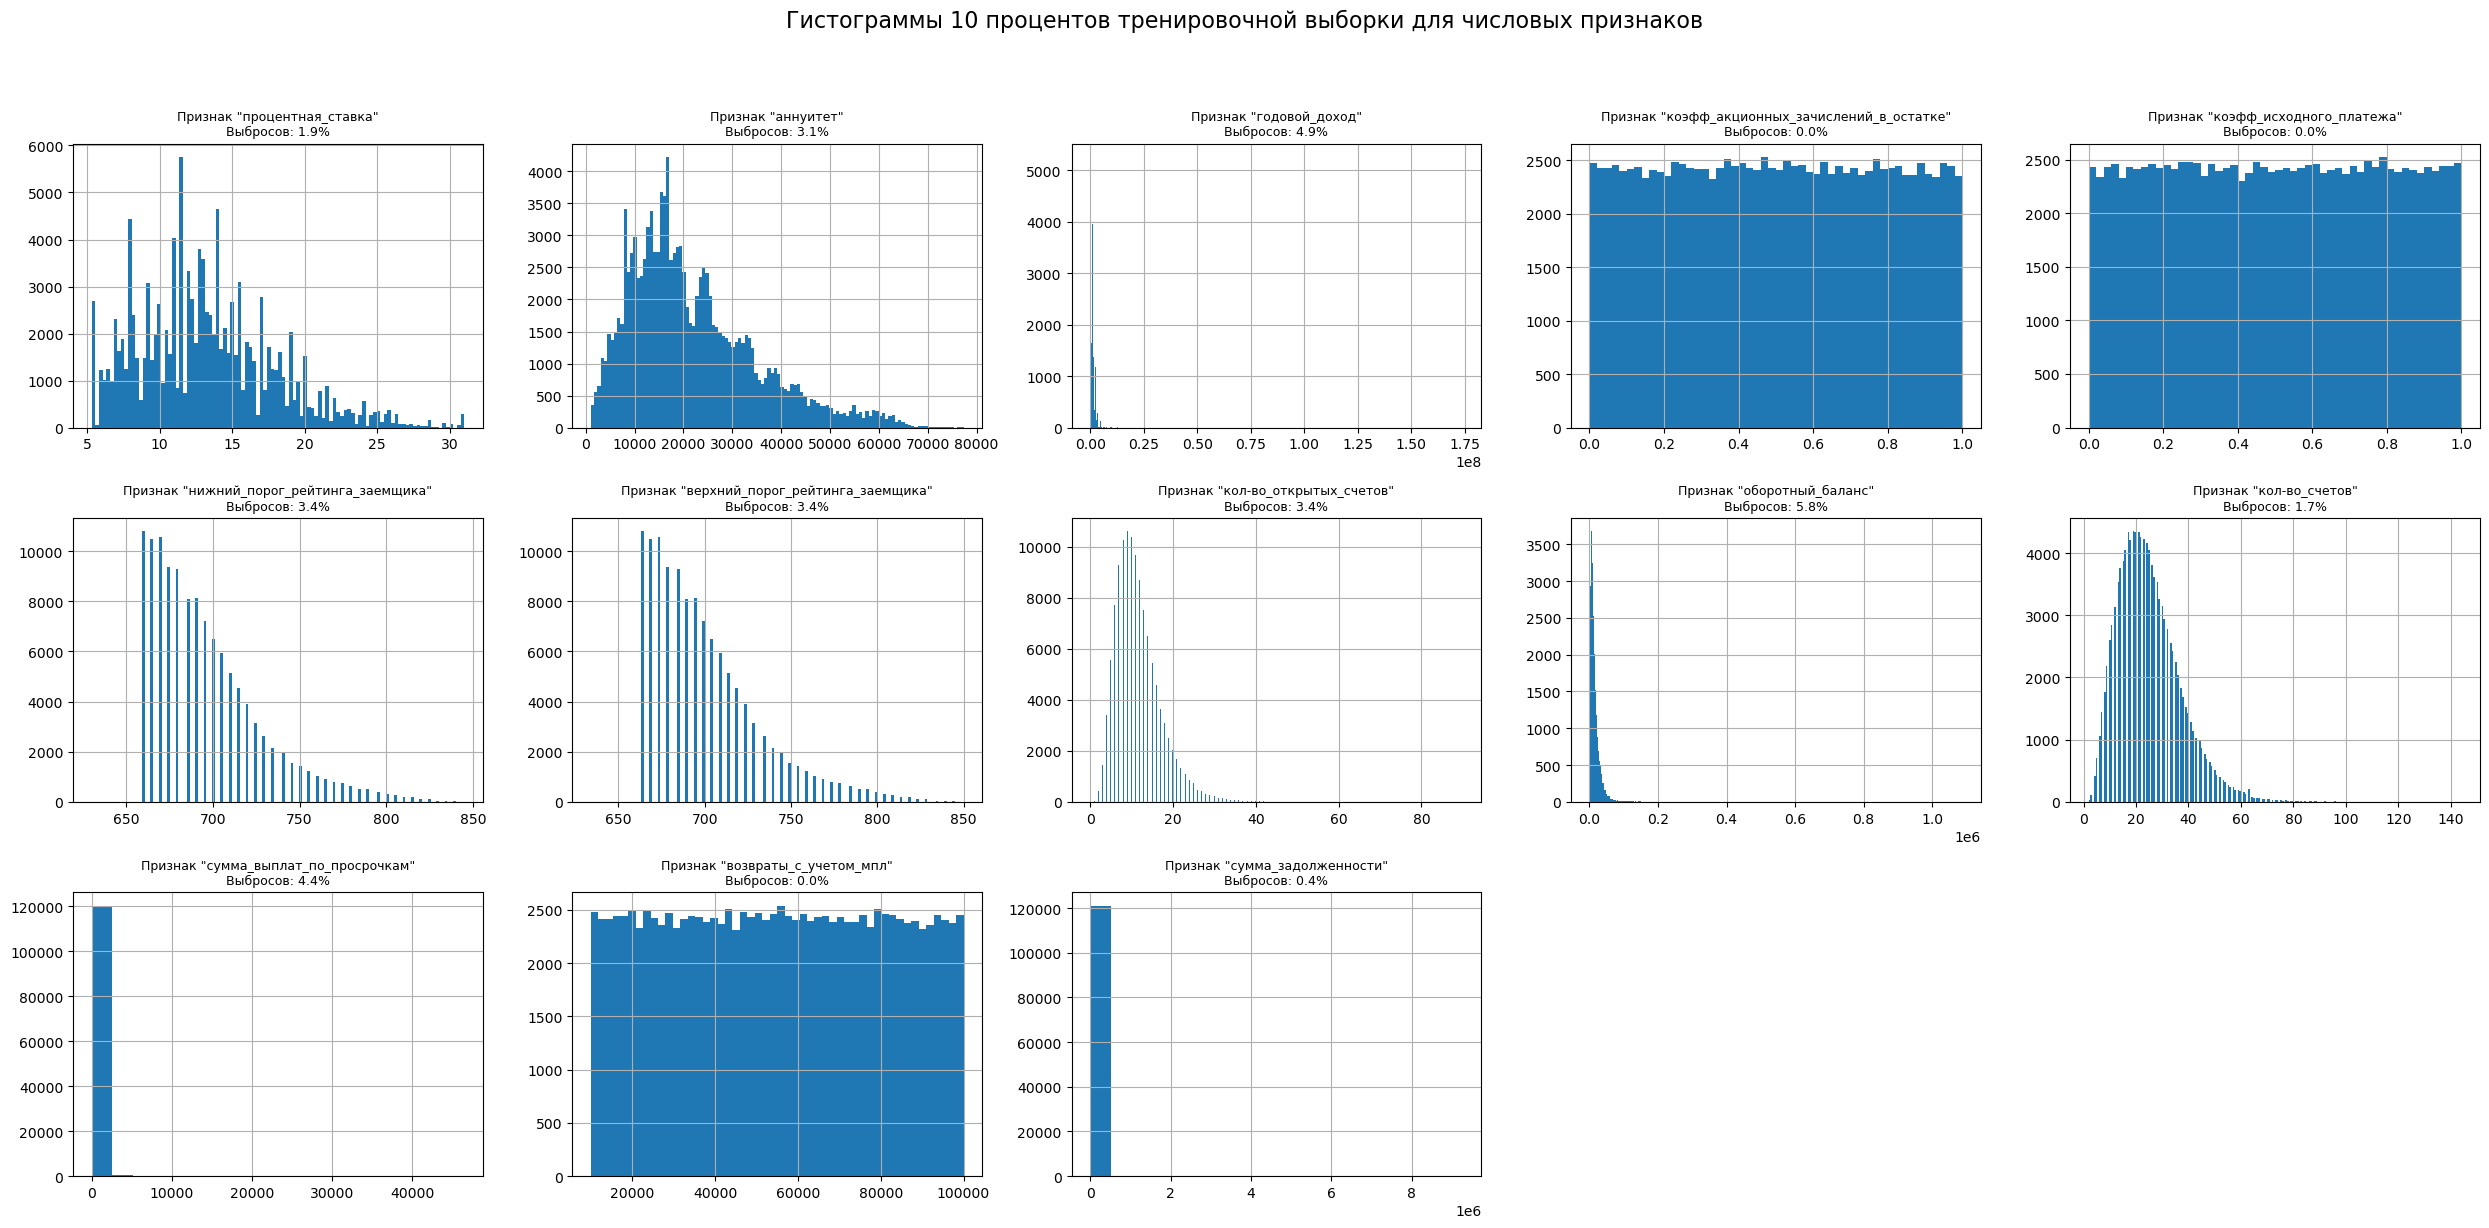

In [19]:
EDA_for_num(df_train_EDA,NUM_COLS)

In [ ]:
sns.countplot(data=df_train_EDA, hue='итоговый_статус_займа',x=i)

Error in callback <function _draw_all_if_interactive at 0x000001E3882AEFC0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [28]:
def EDA_for_cat(df: pd.DataFrame, cat_cols: list):
    n = len(cat_cols)
    cols = 5
    rows = int(np.ceil(n / cols))

    fig, axs = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    axs = axs.flatten()

    for i, col in enumerate(cat_cols):
        ax = axs[i]
        sns.countplot(data=df, hue='итоговый_статус_займа',x=col, order=df[col].value_counts().index, ax=ax)

    for j in range(n, len(axs)):
        fig.delaxes(axs[j])

    fig.suptitle('Столбчатые диаграммы 10 процентов выборки для категориальных признаков', fontsize=16, y=1.02)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

In [ ]:
EDA_for_cat(df_train_EDA,CAT_COLS)

KeyboardInterrupt: 



phik_corr_train = df_train.drop(['id'],axis=1).phik_matrix(interval_cols=lst)

plt.figure(figsize=(15, 8))
sns.heatmap(phik_corr_train, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

In [21]:
all_columns = NUM_COLS + CAT_COLS
df_phik = df_train_EDA[all_columns].copy().fillna('NAN')

In [22]:
df_phik

,сумма_займа,процентная_ставка,аннуитет,годовой_доход,коэфф_акционных_зачислений_в_остатке,индекс_проживания,пдн,коэфф_исходного_платежа,нижний_порог_рейтинга_заемщика,верхний_порог_рейтинга_заемщика,кол-во_месяцев_с_последней_просрочки,кол-во_месяцев_с_последнего_займа,кол-во_открытых_счетов,оборотный_баланс,коэфф_загрузки_возобновляемого_счета,кол-во_счетов,сумма_выплат_по_просрочкам,кол-во_месяцев_с_последнего_нарушения,совокупный_доход_заемщиков,совокупный_пдн_заемщиков,общая_сумма_взысканий,возвраты_с_учетом_мпл,общая_сумма_на_счетах,кол-во_текущих_аннуитетных_счетов,кол-во_месяцев_с_посл_аннуитетного_счета,текущий_баланс_по_аннуитетным_счетам,соотношение_сумм_текущего_баланса_к_лимиту_по_аннуитетным_счетам,кол-во_возоб_счетов_за_2_года,макс_баланс_по_возоб_счетам,соотношение_баланса_к_лимиту_общее,общий_лимит_по_возоб_счету,кол-во_финансовых_операций,кол-во_заявок_на_кредит_за_год,кол-во_открытых_счетов_за_2_года,средний_баланс_текущих_счетов,суммарная_доступная_сумма_займа_по_картам,соотношение_баланса_к_лимиту_по_картам,сумма_задолженности,кол-во_месяцев_с_первого_аннуитетного_счета,кол-во_месяцев_с_первого_возобновляемого_счета,кол-во_месяцев_с_последнего_возобновляемого_счета,кол-во_месяцев_с_последнего_счета,кол-во_месяцев_с_последней_карты,кол-во_мес_с_последней_задолженности_по_карте,кол-во_мес_с_последней_задолженности_по_возобновляемому_счету,кол-во_активных_возобновляемых_счетов,кол-во_карт_без_нарушений,кол-во_карт,кол-во_аннуитетных_счетов,кол-во_открытых_возобновляемых_счетов,кол-во_возобновляемых_счетов,кол-во_возобновляемых_счетов_с_балансом_более_0,кол-во_счетов_без_нарушений,процент_счетов_без_просрочек,процент_счетов_прев_75_лимита,кредитный_лимит,кредитный_баланс_без_ипотеки,лимит_по_картам,лимит_по_аннуитетным_счетам,кредитный_баланс_по_возоб_счетам,срок_займа,рейтинг,допрейтинг,профессия_заемщика,стаж,владение_жильем,подтвержден_ли_доход,платежный_график,цель_займа,регион,пос_стоп_фактор,юридический_статус,дата_первого_займа,первоначальный_статус_займа,пени_за_дефолт,тип_займа,совокупный_статус_подтверждения_доходов_заемщиков,особая_ситуация,тип_предоставления_кредита,итоговый_статус_займа,рейтинг_OCR,кол_во_субсидий_за_год,кол-во_просрочек_за_два_года,коэфф_невыплаченного_сумм_остатка,кол-во_заявок_за_полгода,кол-во_записей_в_общедоступных_документах,непогашенная_сумма_из_тела_займов,дата_следующей_выплаты,грейд_на_детерминаторе,кол-во_взысканий_за_последний_год,код_политики,кол-во_текущих_просроченных_счетов,кол-во_открытых_счетов_за_полгода,кол-во_аннуитетных_счетов_за_год,кол-во_аннуитетных_счетов_за_2_года,кол-во_возоб_счетов_за_год,кол-во_финансовых_запросов,кол-во_списаний_за_год,кол-во_ипотек,кол-во_мес_с_последней_заявки,кол-во_счетов_с_просрочкой_4_мес,кол-во_активных_карт,кол-во_счетов_с_акт_просрочкой_4_мес_обн_2_мес,кол-во_счетов_с_акт_просрочкой_1_мес,кол-во_счетов_с_акт_просрочкой_3_мес_за_2_года,кол-во_счетов_за_посл_год,кол-во_публ_банкротств,кол-во_залогов
677990,1000000.0,6.49,30644.5,1200000.0,0.606238,376.0,19.44,0.643706,740.0,744.0,NAN,NAN,14.0,24782.0,37.7,26.0,0.0,NAN,NAN,NAN,0.0,38293,6168650.0,NAN,NAN,NAN,NAN,NAN,NAN,NAN,3290000.0,NAN,NAN,2.0,440600.0,356150.0,71.0,0.0,134.0,222.0,2.0,2.0,24.0,NAN,NAN,7.0,5.0,8.0,4.0,11.0,20.0,7.0,14.0,100.0,20.0,9259150.0,1754300.0,1230000.0,1250000.0,NAN,3 года,А,А2,обслуживание,5 лет,СОБСТВЕННОСТЬ,Подтвержден источник,n,консолидация_долга,Челябинская область,Нет,Да,9-1993,б,NAN,Индивидуальный,NAN,Нет,Наличные,0,1,0,0.0,1.345312e+06,1.0,0.0,0.0,NAN,3,0.0,1.0,0.0,NAN,NAN,NAN,NAN,NAN,0.0,2.0,2.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0
569123,250000.0,9.16,7969.0,700000.0,0.540621,891.0,21.3,0.650835,660.0,664.0,13.0,75.0,12.0,6236.0,26.4,26.0,0.0,13.0,NAN,NAN,0.0,95723,825450.0,1.0,35.0,513650.0,52.0,6.0,3003.0,38.0,1180000.0,1.0,2.0,6.0,82550.0,718100.0,25.2,0.0,109.0,195.0,2.0,2.0,10.0,NAN,NAN,6.0,5.0,13.0,4.0,11.0,22.0,6.0,12.0,92.0,0.0,2177350.0,825450.0,960000.0,997350.0,NAN,3 года,Б,Б2,уборка помещений,6 лет,СОБСТВЕННОСТЬ,Подтвержден,n,другое